# Designing the winner-take-all (WTA) module 

The winner-take-all (WTA) module is a key component in many neural network models. It is used to select the most active neuron in a group of neurons. The WTA module is used in many applications such as image processing, speech recognition, and pattern recognition. In this notebook, we will design a WTA module using the PyTorch library.

In [1]:
import sys
sys.path.insert(0, '..') 
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
import math
relu = torch.nn.ReLU()

from src.multi_ring_modular_rnn import MultiModRNN, RingModule

/Users/alexnegron/miniconda3/envs/torch/lib/python3.9/site-packages/torch/__init__.py:614: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1699448801785/work/torch/csrc/tensor/python_tensor.cpp:453.)
  _C._set_default_tensor_type(t)


WTA dynamics: 
$$
 x(t+1) = \left( 1-\frac{\Delta t}{\tau} \right) x(t) +  \frac{\Delta t}{\tau} \sigma \left(\alpha \mathbb{I} \cdot x(t) - \beta( \mathbf{1}- \mathbb{I})\cdot \sigma_\phi(x) + b(t) \right) 
$$
where $\mathbf{1}$ is a matrix of all 1s, and $\sigma_\phi(x)$ is a ReLU thresholded at $\phi$, $\alpha$ is the excitatory strength, $\beta$ is the inhibitory strength, and $b(t)$ is the input at time $t$. 

Parameters: 
- $0 <\phi < b_1/(1-\alpha)$
- $1-\beta < \alpha < 1$

Maybe a simpler setup: 
$$
 x(t+1) = \left( 1-\frac{\Delta t}{\tau} \right) x(t) +  \frac{\Delta t}{\tau} \sigma \left(\alpha \mathbb{I} \cdot x(t) - \beta( \mathbf{1}- \mathbb{I})\cdot x(t) + b(t) \right) 
$$

Amounts to tuning $\alpha$ and $\beta$ to get desired WTA dynamics.

In [20]:
class WTAModule():
    def __init__(self, 
                 input_size, 
                 device = 'cpu',
                 num_neurons = 2,
                 dt = 0.5,
                 tau = 10.0,
                 alpha = 1.0,
                 beta = 1.0 
                 ):
        
        super().__init__()
        
        self.device = device
        self.input_size = input_size
        self.num_neurons = num_neurons
        self.dt = dt 
        self.tau = tau 
        self.alpha = dt / tau 
        
        # locally excitatory, globally inhibitory weights
        self.exc = alpha * torch.eye(num_neurons, device=self.device)
        self.inh = beta * (torch.ones(num_neurons, num_neurons, device=self.device) - torch.eye(num_neurons, device=self.device))

        

        # input to WTA module (from integrators, presumably)
        self.input_to_WTA = nn.Linear(input_size, num_neurons, bias=False)


    def init_hidden(self):
        return .5 * torch.ones(self.num_neurons, device=self.device)
    
    def recurrence(self, input, hidden): 
        h2h = hidden @ (self.exc - self.inh)
        i2h = self.input_to_WTA(input)
        h_pre_act = i2h + h2h 

        h_new = (1 - (self.dt / self.tau)) * hidden + (self.dt / self.tau) * relu(h_pre_act)
        return h_new

    def forward(self, input, hidden=None):
        if hidden is None:
            hidden = self.init_hidden()
        
        hidden_list = []
        for t in range(input.size(0)):
            hidden = self.recurrence(input[t, ...], hidden)
            hidden_list.append(hidden)
        
        return hidden_list, hidden
            

In [38]:
# generate uniformly random inputs 
T = 1000 
N = 100
K = 5

inputs = torch.rand(T, 2*N*K)

WTA_module = WTAModule(input_size = 2 * N * K,
                       device = 'cpu',
                       num_neurons = K,
                       alpha = .5,
                       beta = .8
                       )

In [40]:
inputs

tensor([[0.4262, 0.4076, 0.6075,  ..., 0.2412, 0.6765, 0.8385],
        [0.4536, 0.0814, 0.9439,  ..., 0.9551, 0.6182, 0.3742],
        [0.6249, 0.3799, 0.5043,  ..., 0.3568, 0.6135, 0.6267],
        ...,
        [0.6152, 0.2018, 0.5093,  ..., 0.4799, 0.9903, 0.1577],
        [0.9707, 0.0836, 0.0694,  ..., 0.4588, 0.1114, 0.9258],
        [0.7448, 0.8618, 0.3258,  ..., 0.2248, 0.1821, 0.6047]])

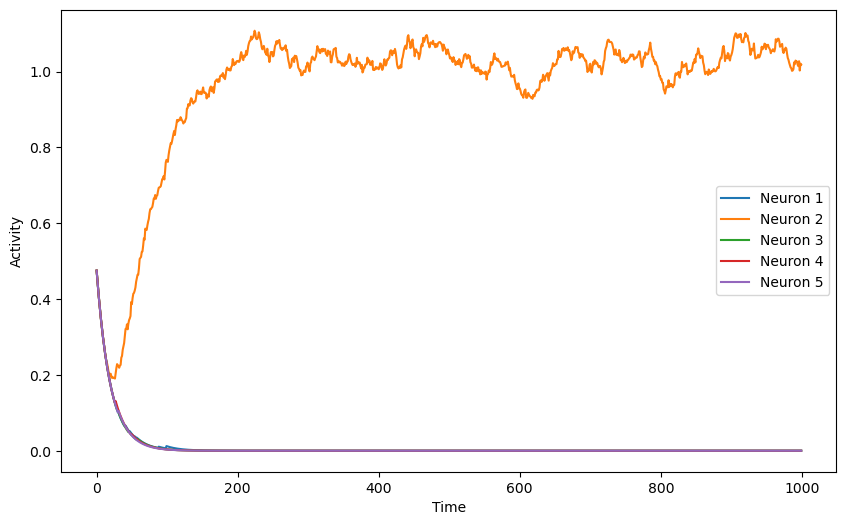

In [39]:
import matplotlib.pyplot as plt

hidden_list, _ = WTA_module.forward(inputs)

neuron_activities = torch.stack(hidden_list).detach().numpy()

plt.figure(figsize=(10, 6))
for i in range(neuron_activities.shape[1]):
    plt.plot(neuron_activities[:, i], label=f'Neuron {i+1}')

plt.xlabel('Time')
plt.ylabel('Activity')
plt.legend()
plt.show()


# Ring modules and WTA module

In [ ]:
import torch 
import torch.nn as nn   
import numpy as np
from src.utils import generate_alpha_matrix
relu = nn.ReLU()

torch.set_default_tensor_type(torch.DoubleTensor)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
# torch.set_default_tensor_type(torch.FloatTensor)
# device = 'mps' if torch.backends.mps.is_built() else 'cpu'


class RingModule(nn.Module):
    def __init__(self,
                 input_size,
                 device='cpu',
                 nNeurons=100,
                 nBumps=1,
                 length=40,
                 gNoiseMag=None,
                 fano=None,
                 dt=0.5,
                 tau=10.0,
                 alpha = 1.0,
                 wWeight=8.0,
                 train_wWeight=False,
                 wShift=2,
                 wScaling=True,
                 restingMag=1.0,
                 gammaMultiplier=1.0,
                 pulseMag = 1.0,
                 pulsePosition = 50
                 ):

        super().__init__()

        self.device = device
        self.input_size = input_size
        self.nNeurons = nNeurons
        self.hidden_size = 2 * self.nNeurons
        self.nBumps = nBumps
        self.dt = dt
        self.length = length
        self.tau = tau
        self.alpha = dt / tau
        self.phiFunction = nn.ReLU()
        self.train_wWeight = train_wWeight
        self.wWeight = nn.Parameter(torch.tensor(wWeight, dtype=torch.float32, device=self.device), requires_grad=train_wWeight)
        self.wShift = wShift
        self.wScaling = wScaling
        self.wAttractor = self.generate_alpha_matrix_diff(self.nNeurons,
                                            self.length,
                                            1.0, 
                                            self.wShift,
                                            self.wScaling,
                                            self.device).to(self.device)

        self.gNoiseMag = gNoiseMag
        self.fano = fano
        self.restingMag = restingMag
        self.gammaMultiplier = gammaMultiplier

        self.pulseMag = pulseMag
        self.pulsePosition = pulsePosition

        # Setup inputs to ring
        self.input_to_vel = nn.Linear(input_size, 1, bias=False).to(device) # learnable
        nn.init.ones_(self.input_to_vel.weight)
        # nn.init.constant_(self.input_to_vel.weight, 0.5) 
        # important! note that this initialization, if random, will cause the hidden activity 
        # initialization to also be random, since the init_hidden() involves running the recurrent dynamics
        # which calls self.input_to_vel 

        self.vel_to_ring = nn.Linear(1, self.hidden_size, bias=True).to(device) # unlearnable
        self.vel_to_ring.weight.requires_grad = False
        self.vel_to_ring.bias.requires_grad = False # fix the bias during training
        self.gamma = (  # Coupling strength between 'velocity' neuron and network
            gammaMultiplier * torch.cat((-torch.ones(self.nNeurons), torch.ones(self.nNeurons))).to(device)
        ).unsqueeze(1)
        self.vel_to_ring.weight.data.copy_(self.gamma); # set coupling from 'velocity' neuron to ring network manually
        self.vel_to_ring.bias.copy_(torch.ones((self.hidden_size,))); # bias is fixed at 1

    def generate_w_matrix_diff(self, device, nNeurons, nBumps, length=40, wShift=2, wScaling=True):
        length2 = int(2 * torch.ceil(torch.tensor(length)))
        positions = torch.arange(-length2, length2 + 1, device=device)
        if wScaling:
            strength = self.wWeight * nBumps / nNeurons
        else:
            strength = self.wWeight

        values = strength * (torch.cos((np.pi * positions / length)) - 1) / 2
        values *= torch.abs(positions) < 2 * length

        wUnshifted = torch.zeros(nNeurons, device=device)
        for position, w in zip(positions, values):
            wUnshifted[position % nNeurons] += w

        wQuadrant = torch.vstack([torch.roll(wUnshifted, i) for i in range(nNeurons)])
        wMatrix = torch.hstack((torch.roll(wQuadrant, -wShift, 0), torch.roll(wQuadrant, wShift, 0)))
        wMatrix = torch.vstack((wMatrix, wMatrix))

        return wMatrix
    
    def generate_alpha_matrix_diff(self, neurons, length, alpha, wShift=2, wScaling=True, device='cpu'):
        cutoff = int((1-alpha)*length)
        wMatrix = self.generate_w_matrix_diff(device, neurons+cutoff, 1, length, wShift, wScaling)
        real_w = torch.zeros((neurons*2,neurons*2), device=device)
        end = 2*neurons + cutoff
        real_w[:neurons,:neurons] = wMatrix[:neurons,:neurons]
        real_w[neurons:,neurons:] = wMatrix[neurons+cutoff:end,neurons+cutoff:end]
        real_w[:neurons,neurons:] = wMatrix[:neurons,neurons+cutoff:end]
        real_w[neurons:,:neurons] = wMatrix[neurons+cutoff:end,:neurons]
        return real_w
    
    def init_hidden(self):
        """
        Initialize the activities in each ring.

        - pulsePosition is chosen to inject a delta pulse of activity at the specified neuron index in each ring.
        - Dynamics are run until bumps stabilize at these positions on each ring.
        - The resulting activities form rings' activity at initialization.
        """

        bump_period = int(self.nNeurons / self.nBumps) # bump distance
        pulse_inds = bump_period * np.arange(self.nBumps)
        pulse_inds = np.concatenate((pulse_inds, self.nNeurons + pulse_inds))

        # pulsePosition = 12 # !important! for now, bumps will always be initialized at the 12th neuron in each ring

        pulse_inds += int(self.pulsePosition % bump_period)
        pulse_inputs = torch.zeros(2 * self.nNeurons, device=self.device)
        pulse_inputs[pulse_inds] = self.pulseMag

        # hidden = 0.005 * torch.rand(2 * self.nNeurons, device=self.device)
        # hidden = 0.05 * torch.rand(2 * self.nNeurons, device=self.device)
        hidden = 0.005 * torch.ones(2 * self.nNeurons, device=self.device) + pulse_inputs

        tSetup = 1_000

        # init_drive = torch.tensor([.1,1,0]).double().to(self.device) # some arbitrary drive to initialize
        # init_drive = torch.tensor([.1]).double().to(self.device) # some arbitrary drive to initialize
        init_drive = torch.full((self.input_size,), 0.1, dtype=torch.double).to(self.device)

        for t in np.arange(0, tSetup): # run dynamics a little
            hidden = self.recurrence(init_drive, hidden)

        while (torch.argmax(hidden[:self.nNeurons]) - self.pulsePosition != 0):
            hidden = self.recurrence(init_drive, hidden)

        # print('bumps initialized')

        return hidden


    def recurrence(self, input, hidden):
        # h2h = torch.matmul(self.wAttractor, hidden.T)
        h2h = hidden @ self.wAttractor
        i2h = self.vel_to_ring(self.input_to_vel(input))
        h_pre_act = i2h + h2h

        h_new = (1 - self.alpha)*hidden + self.alpha*relu(h_pre_act)
        return h_new

    def forward(self, input, hidden=None):
        if hidden is None: # initialize ring neuron states
            hidden = self.init_hidden()

        
        if self.train_wWeight: # update ring module weights 
            self.wAttractor = self.generate_alpha_matrix_diff(self.nNeurons,
                                                self.length,
                                                1.0, 
                                                self.wShift,
                                                self.wScaling,
                                                self.device).to(self.device)
            # clamp wWeight to ensure it stays within given range 
            self.wWeight.data.clamp_(5.0, 15.0)


        # propagate input through ring module
        recurrent_acts = []
        steps = range(input.shape[0])
        for t in steps:
            hidden = self.recurrence(input[t, ...], hidden)

            # store ring network activity
            recurrent_acts.append(hidden)

        hidden_acts = torch.stack(recurrent_acts, dim=0)

        return hidden_acts,  hidden
    

class WTAModule():
    def __init__(self, 
                 input_size, 
                 device = 'cpu',
                 num_neurons = 2,
                 dt = 0.5,
                 tau = 10.0,
                 alpha = 1.0,
                 beta = 1.0 
                 ):
        
        super().__init__()
        
        self.device = device
        self.input_size = input_size
        self.num_neurons = num_neurons
        self.dt = dt 
        self.tau = tau 
        self.alpha = dt / tau 
        
        # locally excitatory, globally inhibitory weights
        self.exc = alpha * torch.eye(num_neurons, device=self.device)
        self.inh = beta * (torch.ones(num_neurons, num_neurons, device=self.device) - torch.eye(num_neurons, device=self.device))

        # input to WTA module (from integrators, presumably)
        self.input_to_WTA = nn.Linear(input_size, num_neurons, bias=False)


    def init_hidden(self):
        return .5 * torch.ones(self.num_neurons, device=self.device)
    
    def recurrence(self, input, hidden): 
        h2h = hidden @ (self.exc - self.inh)
        i2h = self.input_to_WTA(input)
        h_pre_act = i2h + h2h 

        h_new = (1 - (self.dt / self.tau)) * hidden + (self.dt / self.tau) * relu(h_pre_act)
        return h_new

    def forward(self, input, hidden=None):
        if hidden is None:
            hidden = self.init_hidden()
        
        hidden_list = []
        for t in range(input.size(0)):
            hidden = self.recurrence(input[t, ...], hidden)
            hidden_list.append(hidden)
        
        return hidden_list, hidden
            



class MultiModRNN(torch.nn.Module):
    def __init__(self, input_size, output_size, n_modules, **kwargs):
        super().__init__()

        module_list = [RingModule(input_size, **kwargs) for _ in range(n_modules)]
        module_list.append(WTAModule(input_size, **kwargs))
        
        self.mods = nn.ModuleList(module_list)

        

        # output from modular layer
        self.output = torch.nn.Linear(n_modules * self.mods[0].hidden_size, output_size, bias=True).to(device)
        
    def forward(self, x):
        activities = []
        for mod in self.mods:
            activity, _ = mod(x)
            activities.append(activity)

        activity = torch.cat(activities, dim=-1)
        out = self.output(activity)

        return out, activity
